## Feature Selection Methods

This notebook walks through a few different methods for feature selection, explaining the methodology for each one and saving the feature selected datasets either to Amazon S3 or to disk. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import boto3
import s3fs
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from itertools import compress
import matplotlib.pyplot as plt
import random
plt.style.use('ggplot')
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from auth import access_key, secret_key
from Evaluator import Evaluator

### Setup
We start by configuring the input paths to our data and reading in the data into a pandas dataframe. Alter the filepath variables for input files and outpath to adjust where the featureselected files are saved. 

In [2]:
# Alter with location of input files as needed
train_filepath = "s3://voightlab-data/t2d/t2d_train.csv"
test_filepath = "s3://voightlab-data/t2d/t2d_test.csv"

# Used to name the output files
outpath = "voightlab-data/t2d/FeatureSelected/"

In [ ]:
# Only necessary for AWS usage
os.environ["AWS_ACCESS_KEY_ID"] = access_key
os.environ["AWS_SECRET_ACCESS_KEY"] = secret_key

In [4]:
train_df = pd.read_csv(train_filepath, index_col=0)
test_df = pd.read_csv(test_filepath, index_col=0)

train_df.dropna(how='any')
test_df.dropna(how='any')
train_df.head()

,type,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,36
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


Replace the array 'labels' with the target values you are trying to predict for. 

In [5]:
# Create training and test splits, dropping labels and sample weights from training set

'''
For multilabel use below:
labels = ['is_BMI', 'is_CAD', 'is_T2D', 'is_lipids']
''' 

labels= ['type']

X_train = train_df.drop(labels, axis=1)
y_train = train_df.loc[:, labels]

X_test = test_df.drop(labels, axis=1)
y_test = test_df.loc[:, labels]

In [6]:
# Create combined dataset case we want to run feature selection tests on the entire combined dataset
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [7]:
X_test.head()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,53
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,18
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,37
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [8]:
# Init object for visualization and evaluation
# See Evaluator.py for documentation of methods in this class
ev = Evaluator()

To write to local storage instead of S3, replace all instances of `write_to_s3` below with `write_local`

In [9]:
# For storage once we have done the feature selection
def write_to_S3(df, filename):
    bytes_to_write = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
    print (outpath + filename + " written") 
    with fs.open(outpath + filename, 'wb') as f:
        f.write(bytes_to_write)

# If not using S3
def write_local(df, filename):
    pd.to_csv(outpath + filename)

### Variance Threshold

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet our specified threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples. This method only looks at the features, not the labels. This means that it can be used in unsupervised learning, however it is not accounting for any particular distinctions between the controls and positives. 

In a dataset with boolean features we can remove all features that are either one or zero in more than a certain % of the samples. We can further prune the feature set by taking only the top n features in terms of displaying the most variance.

Since boolean variables are Bernoulli random variables, their variance is given by p(1-p). So as an example, if we want to remove all features that are either one or zero (on or off) in more than 80% of the samples then we woould set the threshold parameter of the selector to = .80 * (1 - 0.80).

A note on this approach in this instance is that it might not be particularly effective for such an imbalanced dataset, as features displaying the most variation could display that variation all within the larger control class. 

In [10]:
try:
    selector = VarianceThreshold(threshold=.80 * (1 - .80))
    selector.fit_transform(X_train, y_train)
except ValueError:
    print ("No feature in X meets the variance threshold 0.09000")

In [11]:
print ("Features remaining in the featureset: {}".format(len(selector.variances_)))

Features remaining in the featureset: 2748


Here we set n to some number, representing the number of features that we want to keep. We obtain the indices of elements with the highest variance and create a new dataframe for training containing only those features.

In [12]:
# Select the top n features, where features are ranked based on how much variance they display
n = 800
top_idx = np.argsort(selector.variances_)[-n:]
vt_features = [selector.variances_[i] for i in top_idx]
vt_traindf = X_train.iloc[:, top_idx]
vt_testdf = X_test.iloc[:, top_idx]

In [13]:
vt_traindf.head()

,E116-H2A.Z.gappedPeak,E069-H3K36me3.gappedPeak,E103-H3K36me3.gappedPeak,E128-H3K27ac.gappedPeak,E098-DNase.hotspot.fdr0.01.broad.bed,keratinocyte_transcription_profiling_by_array_assay_ENCFF001SOA.bed,E119-H3K27ac.gappedPeak,E097-DNase.hotspot.fdr0.01.broad.bed,E023-H3K36me3.gappedPeak,E024-H3K4me1.gappedPeak,...,E003-H3K4me1.gappedPeak,E030-H3K27me3.gappedPeak,E044-H3K27me3.gappedPeak,E127-H3K4me1.gappedPeak,E021-H3K4me1.gappedPeak,E002-H3K36me3.gappedPeak,E114-H3K4me1.gappedPeak,E095-H3K4me1.gappedPeak,E084-H3K9me3.gappedPeak,snpcount
0,1,1,1,0,0,0,0,0,1,1,...,0,0,1,1,0,1,0,0,0,11
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,5
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1,1,1,0,1,1,0,0,1,1,...,0,0,0,1,1,1,1,1,1,36
4,0,1,1,0,0,0,0,0,1,1,...,1,1,0,0,0,0,0,1,0,2


In [14]:
# Write the created dataset to a file so we can test model performance later
write_to_S3(vt_traindf, "var_threshold/X_train.csv")
write_to_S3(y_train, "var_threshold/y_train.csv")
write_to_S3(vt_testdf, "var_threshold/X_test.csv")
write_to_S3(y_test, "var_threshold/y_test.csv")

voightlab-data/t2d/FeatureSelected/var_threshold/X_train.csv written
voightlab-data/t2d/FeatureSelected/var_threshold/y_train.csv written
voightlab-data/t2d/FeatureSelected/var_threshold/X_test.csv written
voightlab-data/t2d/FeatureSelected/var_threshold/y_test.csv written


### Univariate Feature Selection

The sklearn GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows us to select the best univariate selection strategy with a hyper-parameter search estimator, similar to grid search. Here I've compared the association of the features to a target variable using a chi square test and sklearn's mutual info classificaion test. 

First we set the scoring parameter of the class to the chi2 test, selecting the n best performing features, i.e, the features with the n highest values for the test chi-squared statistic. Here, we are measuring whether each categorical feature is independent of the target class. We assume a null hypothesis that the frequencies of each variable is similarly distributed to the features of the classes. If we cannot reject the null hypothesis for a variable, we dispose of that feature. 

It should be noted that the sklearn implementation of the chi squared test only considers features where x=1. I.e, it looks at features where x=1 and sees if the distribution of values for y matches that of the overall population.

In [15]:
# Return n best features based on the test
n = 125
chi_gus = GenericUnivariateSelect(chi2, mode='k_best', param=n)
chi_idx = []
chi_features = []
chi_pvalues = []

# loop allows us to account for multilabel problems
# We fit individually for each label
for label in labels:
    chi_gus.fit(X_train, y_train[label])

    # Save features using the boolean mask 
    chi_idx += list(chi_gus.get_support())
    chi_pvalues += list(compress(chi_gus.pvalues_, chi_idx))
    chi_features += list(compress(X_train, chi_idx))

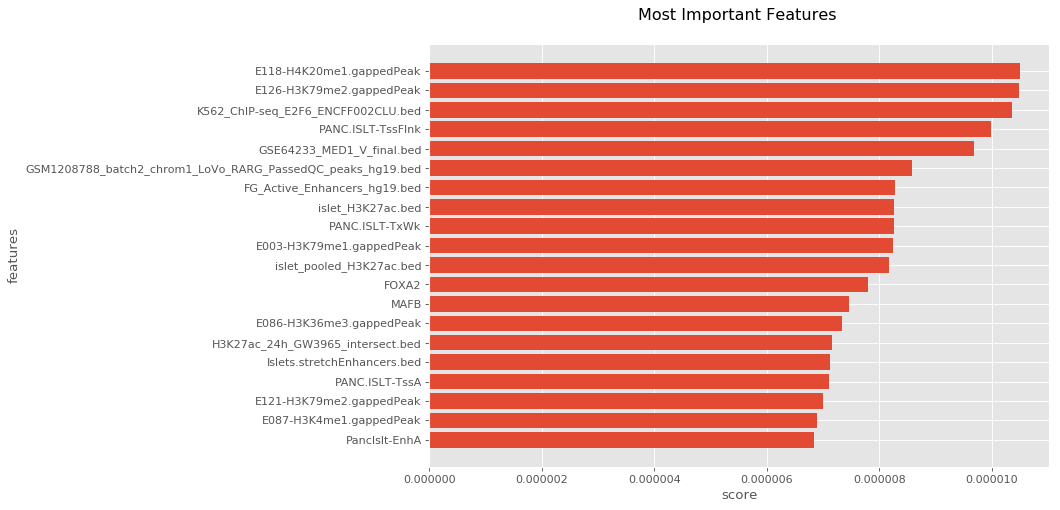

In [16]:
# Visualize p values for top n feature from test
important_features = ev.feat_importance(set(chi_pvalues), set(chi_features), n=20)

Now we try again using the mutual info classification test. Mutual information for each feature x and y is a measure of their mutual dependence. More generally, it determines how similar the joint distribution p(x, y) is to the products of factored marginal distribution p(x) * p(y). Mutual information is the expected value of the pointwise mutual information.   

In [17]:
mic_gus = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=n)
mic_idx = []
mic_features = []
mic_scores = []

for label in labels:
    mic_gus.fit(X_train, y_train[label])

    # Save features using the boolean mask 
    mic_idx += list(mic_gus.get_support())
    mic_features += list(compress(X_train.columns, mic_idx)) 
    mic_scores += list(compress(mic_gus.scores_, mic_idx))

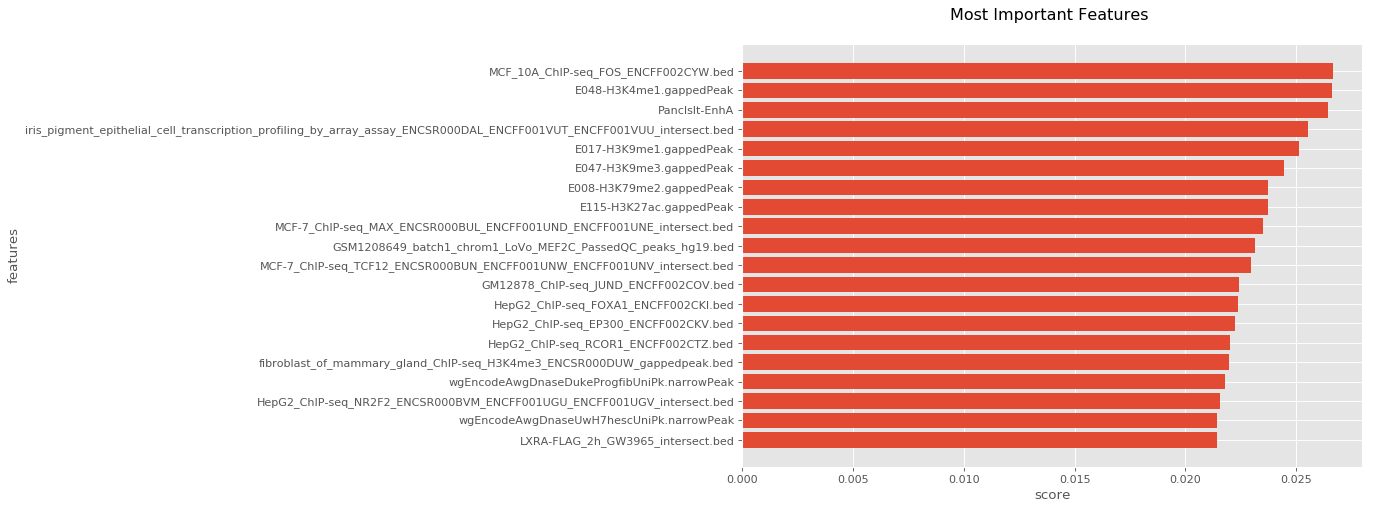

In [18]:
# Visualize scores for top n feature from test
important_features = ev.feat_importance(set(mic_scores), set(mic_features), n=20)

In [19]:
# Save training and testing datframes only consisting of the features we have selected
chi_Xtraindf = X_train.loc[:, list(set(chi_features))]
chi_Xtestdf = X_test.loc[:, list(set(chi_features))]

# Write the created dataset to a file so we can test model performance later
write_to_S3(chi_Xtraindf, "chi2/X_train.csv")
write_to_S3(y_train, "chi2/y_train.csv")
write_to_S3(chi_Xtestdf, "chi2/X_test.csv")
write_to_S3(y_test, "chi2/y_test.csv")

voightlab-data/t2d/FeatureSelected/chi2/X_train.csv written
voightlab-data/t2d/FeatureSelected/chi2/y_train.csv written
voightlab-data/t2d/FeatureSelected/chi2/X_test.csv written
voightlab-data/t2d/FeatureSelected/chi2/y_test.csv written


In [20]:
# Write joint datasets so that we have those on hand too
write_to_S3(pd.concat([chi_Xtraindf, y_train], axis=1), "chi2/df_train.csv")
write_to_S3(pd.concat([chi_Xtestdf, y_test], axis=1), "chi2/df_test.csv")

voightlab-data/t2d/FeatureSelected/chi2/df_train.csv written
voightlab-data/t2d/FeatureSelected/chi2/df_test.csv written


In [21]:
# Save training and testing datframes only consisting of the features we have selected
mic_Xtraindf = X_train.loc[:, list(set(mic_features))]
mic_Xtestdf = X_test.loc[:, list(set(mic_features))]

# Write the created dataset to a file so we can test model performance later
write_to_S3(mic_Xtraindf, "mic/X_train.csv")
write_to_S3(y_train, "mic/y_train.csv")
write_to_S3(mic_Xtestdf, "mic/X_test.csv")
write_to_S3(y_test, "mic/y_test.csv")

voightlab-data/t2d/FeatureSelected/mic/X_train.csv written
voightlab-data/t2d/FeatureSelected/mic/y_train.csv written
voightlab-data/t2d/FeatureSelected/mic/X_test.csv written
voightlab-data/t2d/FeatureSelected/mic/y_test.csv written


In [22]:
# Write joint datasets so that we have those on hand too
write_to_S3(pd.concat([mic_Xtraindf, y_train], axis=1), "mic/df_train.csv")
write_to_S3(pd.concat([mic_Xtestdf, y_test], axis=1), "mic/df_test.csv")

voightlab-data/t2d/FeatureSelected/mic/df_train.csv written
voightlab-data/t2d/FeatureSelected/mic/df_test.csv written


### Feature Agglomeration

Uses agglomerative bottom up clustering to merge features together. Each feature starts off in its own cluster and we merge features together to create larger and larger clusters. Here we're going to use a randomized approach to feature selection where we begin by choosing the number of features 'n' and clustering features together with others that appear to be similar. Then we look at each of the n clusters and select one random feature from each cluster. 

In [23]:
n = 50 
fa_selector = FeatureAgglomeration(n_clusters=n, affinity='manhattan', linkage='complete')

In [24]:
fa_selector.fit(X_train)
labels = fa_selector.labels_

In [25]:
# Create a dictionary with labels as keys and the values being a list of all features assigned to that label
assignments = {}

for label, feature in zip(labels, X_train.columns):
    if label in assignments:
        assignments[label].append(feature)
    else:
        assignments[label] = [feature]

In [26]:
fa_features = []

for label, featurelist in assignments.items():
    chosen_feature = random.choice(featurelist)
    fa_features.append(chosen_feature)

fa_Xtraindf = X_train[fa_features]
fa_Xtestdf = X_test[fa_features]

In [27]:
# Write the created dataset to a file so we can test model performance later
write_to_S3(fa_Xtraindf, "fa/X_train.csv")
write_to_S3(y_train, "fa/y_train.csv")
write_to_S3(fa_Xtestdf, "fa/X_test.csv")
write_to_S3(y_test, "fa/y_test.csv")

voightlab-data/t2d/FeatureSelected/fa/X_train.csv written
voightlab-data/t2d/FeatureSelected/fa/y_train.csv written
voightlab-data/t2d/FeatureSelected/fa/X_test.csv written
voightlab-data/t2d/FeatureSelected/fa/y_test.csv written


### Recursive Feature Elimination


Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

We can use a different technique to drop the number of features below a reasonable size - say the chi squared test - and recursively eliminate from there. 

In [28]:
if len(X_train.columns) > len(X_train):
    n = 2000
    chi_gus = GenericUnivariateSelect(chi2, mode='k_best', param=n)
    chi_gus.fit(X_train, y_train)

    # Save features using the boolean mask 
    chi_idx = chi_gus.get_support()
    chi_features = list(compress(X_train.columns, chi_idx)) 

In [29]:
if len(X_train.columns) > len(X_train):
    X_train = X_train[chi_features]
    X_test = X_test[chi_features]

In [39]:
rfecv_features = []
feature_names = []
step = 100
multilabel = False

if multilabel:
    for label in labels:
        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear", class_weight='balanced')
        rfecv = RFECV(estimator=svc, step=step, cv=StratifiedKFold(2), scoring='recall_micro', n_jobs=1)
        rfecv.fit(X_train, y_train[label])

        print("Optimal number of features for label {} : {}".format(label, rfecv.n_features_))
        rfecv_features.append(rfecv.support_)
        optimal_df = X_train.loc[:, rfecv.support_]
        feature_names += list(optimal_df.columns)

else:
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel="linear", class_weight='balanced')
    rfecv = RFECV(estimator=svc, step=step, cv=StratifiedKFold(2), scoring='recall', n_jobs=1)
    rfecv.fit(X_train, y_train)

    print("Optimal number of features is {}".format(rfecv.n_features_))
    rfecv_features.append(rfecv.support_)
    optimal_df = X_train.loc[:, rfecv.support_]
    feature_names += list(optimal_df.columns)  

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal number of features is 100


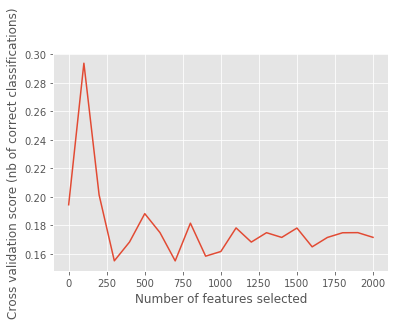

In [40]:
# Plot number of features VS. cross-validation scores
if not multilabel:
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(0, n+step, step), rfecv.grid_scores_)
    plt.show()

The dataframe with the selected features:

In [41]:
feature_names = list(set(feature_names))
X_train.loc[:, feature_names].head()

,MUS.SKLT.F-TssA,GSM1218851_Rhabdomyosarcoma_MyoD.bed,GSM1240833_GP5dsiRAD21_JUND_peaks_hg19.bed,osteoblast_ChIP-seq_EP300_ENCFF001TCZ.bed,H1-hESC_ChIP-seq_ATF2_ENCFF002CIR.bed,PANC.ISLT-TssBiv,E048-H3K36me3.gappedPeak,GSM1208807_batch2_chrom1_LoVo_VEZF1_PassedQC_peaks_hg19.bed,Hsmm-Tx,HeLa-S3_ChIP-seq_POLR3A_ENCFF002CTD.bed,...,GSM1208665_batch1_chrom1_LoVo_NR2F2_PassedQC_peaks_hg19.bed,LXRA-FLAG_2h_GW3965_intersect.bed,bronchial_epithelial_cell_ChIP-seq_H3K4me3_ENCSR000DXJ_gappedpeak.bed,E050-H3K4me3.gappedPeak,GM12878_ChIP-seq_EGR1_ENCFF002CGW.bed,E089-H3K4me3.gappedPeak,SK-N-MC_ChIP-seq_H3K4me3_ENCSR000DXL_gappedpeak.bed,E059-H3K36me3.gappedPeak,islet_pooled_H3K27ac.bed,PANC.ISLT-Tx
0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0
4,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Save training and testing datframes only consisting of the features we have selected
rfecv_Xtraindf = X_train[ feature_names]
rfecv_Xtestdf = X_test[feature_names]

# Write the created dataset to a file so we can test model performance later
write_to_S3(rfecv_Xtraindf, "rfecv/X_train.csv")
write_to_S3(y_train, "rfecv/y_train.csv")
write_to_S3(rfecv_Xtestdf, "rfecv/X_test.csv")
write_to_S3(y_test, "rfecv/y_test.csv")

# Write joint datasets so that we have those on hand too
write_to_S3(pd.concat([rfecv_Xtraindf, y_train], axis=1), "rfecv/df_train.csv")
write_to_S3(pd.concat([rfecv_Xtestdf, y_test], axis=1), "rfecv/df_test.csv")

voightlab-data/t2d/FeatureSelected/rfecv/X_train.csv written
voightlab-data/t2d/FeatureSelected/rfecv/y_train.csv written
voightlab-data/t2d/FeatureSelected/rfecv/X_test.csv written
voightlab-data/t2d/FeatureSelected/rfecv/y_test.csv written
voightlab-data/t2d/FeatureSelected/rfecv/df_train.csv written
voightlab-data/t2d/FeatureSelected/rfecv/df_test.csv written
